In [1]:
import lsdb
from tape import Ensemble, ColumnMapper
import matplotlib.pyplot as plt

# LSDB+TAPE Demo: Gaia + ZTF Box-Search Crossmatch & Lightcurve Analysis

In this demo, we'll show a brief example LSDB+TAPE workflow using a Gaia and ZTF. With LSDB, we'll explore using the box search method to select a small sample from the full dataset, and show how to cross-match ZTF and Gaia. With TAPE, we'll show how to perform time-domain analysis on the ZTF lightcurves tied to the cross-matched dataset. The datasets will pull from hipscat versions of these surveys available here: https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/

The goal of this notebook is to provide example code for working with Gaia and ZTF data, and using this as the foundation for your own analysis with LSDB/TAPE and Gaia/ZTF is highly encouraged.

> **_NOTE:_** This notebook features software that is actively being developed. As such, the workflow and API is subject to change. If using this as the basis for scientific work, we highly encourage you to check the validity of your results.

## Installation and Dependencies

TAPE (>=v0.3.4): https://tape.readthedocs.io/en/latest/gettingstarted/installation.html 
```
pip install lf-tape
```
LSDB (>=v0.1.2): https://lsdb.readthedocs.io/en/latest/
```
pip install lsdb
```

This notebook also requires hipscat>=0.2.5, which should be installed via LSDB

## Reading into LSDB

In [2]:
#Setup Paths

# If running on epyc, please set the temp path to avoid clogging the shared tmp space
#import dask
#dask.config.set({'temporary_directory': '/data/epyc/users/[YOUR_USERNAME]/tmp'})

# Gaia
gaia_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/gaia_dr3/gaia"

# ZTF
ztf_object_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_dr14/"
ztf_source_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_source/"
# optionally can use Zubercal for ztf sources (observations) instead
#ztf_source_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/zubercal/"

> **_NOTE:_** Doing anything at scale with these links will be slow/impossible, you should replace these with paths to the hipscat surveys that are local to your compute environment if interested. If you can access epyc, the links are:
>
> gaia_path = "/astro/store/epyc3/data3/hipscat/catalogs/gaia_dr3/gaia"
> 
> ztf_object_path = "/astro/store/epyc3/data3/hipscat/catalogs/ztf_axs/ztf_dr14"
> 
> ztf_source_path = "/astro/store/epyc3/data3/hipscat/catalogs/ztf_axs/ztf_source/"
>
> Or use Zubercal:
> 
> ztf_source_path = "/astro/store/epyc3/data3/hipscat/catalogs/zubercal"

In [3]:
%%time
# Load into LSDB Catalog objects
gaia_object = lsdb.read_hipscat(gaia_path) # Gaia (Object)
ztf_object = lsdb.read_hipscat(ztf_object_path) # ZTF Object
ztf_source = lsdb.read_hipscat(ztf_source_path) # ZTF Source

CPU times: user 16.2 s, sys: 8.15 s, total: 24.4 s
Wall time: 1min 15s


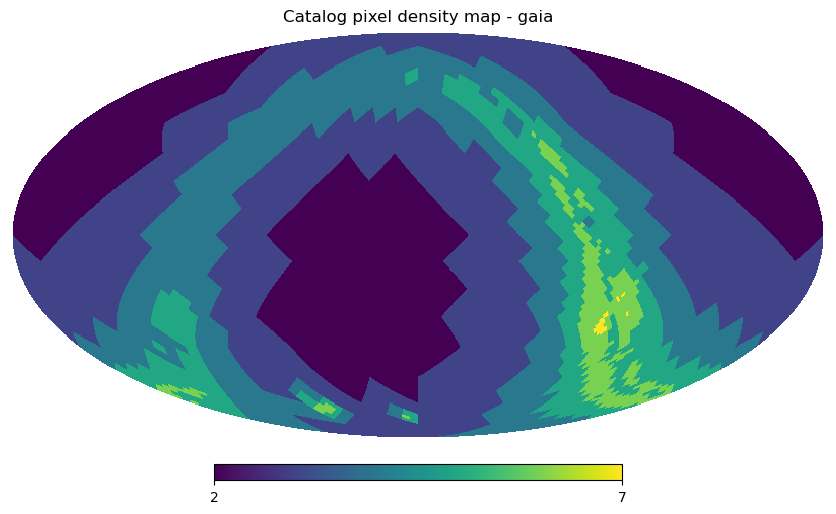

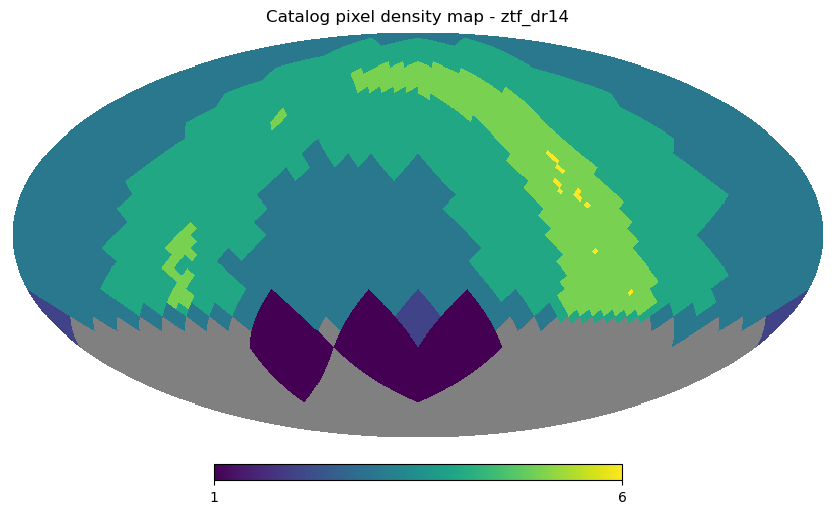

In [4]:
# Plot the Pixel Density Maps for Gaia and ZTF
from hipscat.inspection import plot_pixels

plot_pixels(gaia_object.hc_structure)
plot_pixels(ztf_object.hc_structure)


## Applying a Box Search

In [5]:
%%time
# Box Search
ra = (340, 341)
dec = (10, 11)
gaia_object = gaia_object.box(ra=ra, dec=dec)
ztf_object = ztf_object.box(ra=ra, dec=dec)
ztf_source = ztf_source.box(ra=ra, dec=dec)

CPU times: user 6.8 s, sys: 89.4 ms, total: 6.89 s
Wall time: 6.89 s


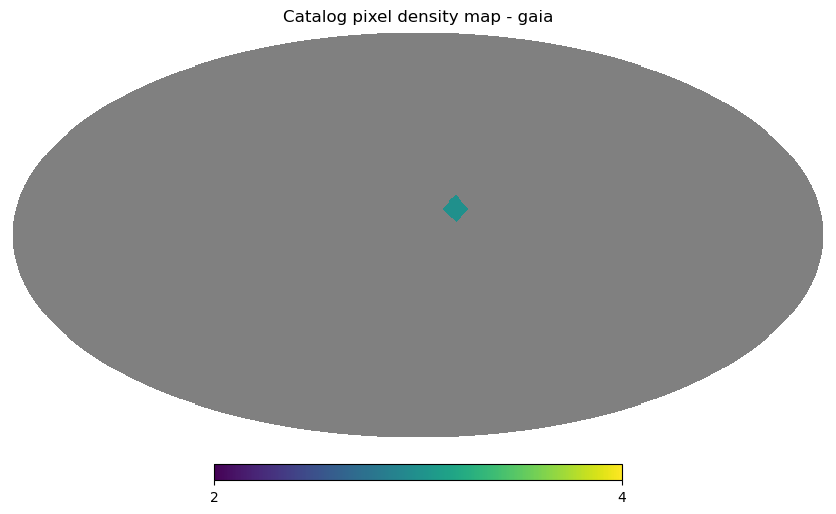

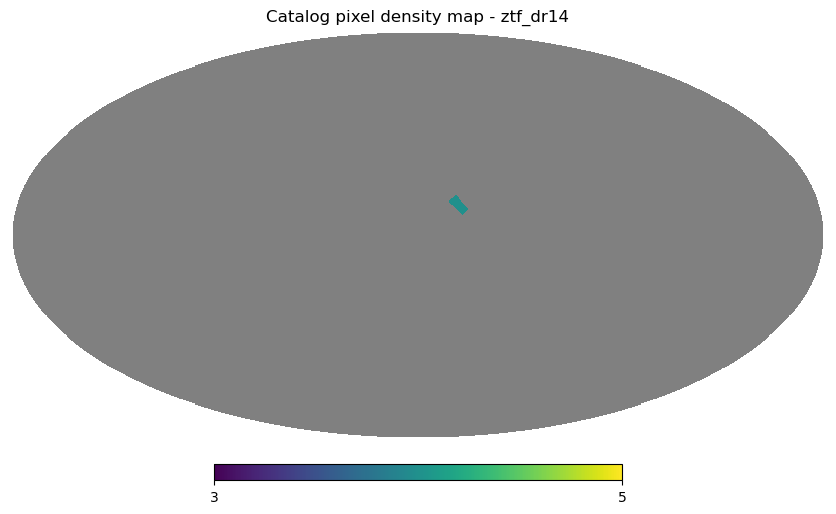

In [6]:
# Plot the Pixel Density Maps for the box searched Gaia and ZTF
from hipscat.inspection import plot_pixels

plot_pixels(gaia_object.hc_structure)
plot_pixels(ztf_object.hc_structure)

In [8]:
%%time

# The resulting catalogs should fit into memory (if box is small), let's "persist" to speed up the remaining cells
# Persist: Begins computation, all future work points to the result of this computation, rather than doing it again itself
# This will take some time, but will be worth it for executing the rest of the cells
# We have to do this at the dask level (_ddf, dask dataframe) at the moment
gaia_object._ddf = gaia_object._ddf.persist()
ztf_object._ddf = ztf_object._ddf.persist()
ztf_source._ddf = ztf_source._ddf.persist()

CPU times: user 3min 50s, sys: 4.26 s, total: 3min 54s
Wall time: 4min 4s


## Cross-matching

In [9]:
# Cross-match Gaia and ZTF

xmatch_object = ztf_object.crossmatch(gaia_object)

xmatch_object.head(5)

/Users/dbranton/miniforge3/envs/ray310/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:100: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,...,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Dir_gaia,Npix_gaia,_DIST
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5433293159180271616,120013408788005954,340.878784,10.012841,20.756800,19.654200,19.116301,18,44,28,20.830534,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000038
5433297910915661824,120013409799093573,340.979919,10.010910,15.549300,15.084400,14.909200,375,457,66,15.572925,...,0.2212,0.236,0.1227,0.1185,0.1265,MARCS,3,0,301,0.000034
5433297981908451328,120023409860913742,340.986115,10.019347,22.060699,20.752501,19.318800,19,253,60,21.645420,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000035
5433302909825581056,120003409338781961,340.933818,10.001028,21.908800,20.790199,20.013901,10,194,46,21.692529,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000026
5433302948404789248,120003409232517259,340.923269,10.005639,22.367300,21.164801,19.846901,3,120,55,21.435994,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000033


In [10]:
# See the number of objects from the crossmatch
len(xmatch_object._ddf)

5140

## TAPE: Working with the Lightcurves

### Transitioning from LSDB to TAPE

In [13]:
%%time
# Loading into TAPE

# We do this to get the source catalog indexed by the objects hipscat index
# if using zubercal, right_on should be "objectid" instead
joined_source = xmatch_object.join(
    ztf_source, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid", suffixes=("", "")
)

# Loading into TAPE
ens = Ensemble()

# You may also want to try using a distributed client, opening up access to helpful resources
# like the dask dashboard: https://docs.dask.org/en/latest/dashboard.html
#from dask.distributed import Client
#client = Client(n_workers=4)
#ens = Ensemble(client=client)

# The ColumnMapper maps dataset columns to a few timeseries quantities
colmap = ColumnMapper().use_known_map("ZTF", hipscat=True)

# Read from LSDB catalogs
ens.from_lsdb(joined_source, xmatch_object, column_mapper=colmap, sync_tables=True)

ens.object.head(5, npartitions=-1)

CPU times: user 1.09 s, sys: 1.28 s, total: 2.38 s
Wall time: 1.69 s


,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,...,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Dir_gaia,Npix_gaia,_DIST
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5433293159180271616,120013408788005954,340.878784,10.012841,20.756800,19.654200,19.116301,18,44,28,20.830534,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000038
5433297910915661824,120013409799093573,340.979919,10.010910,15.549300,15.084400,14.909200,375,457,66,15.572925,...,0.2212,0.236,0.1227,0.1185,0.1265,MARCS,3,0,301,0.000034
5433297981908451328,120023409860913742,340.986115,10.019347,22.060699,20.752501,19.318800,19,253,60,21.645420,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000035
5433302909825581056,120003409338781961,340.933818,10.001028,21.908800,20.790199,20.013901,10,194,46,21.692529,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000026
5433302948404789248,120003409232517259,340.923269,10.005639,22.367300,21.164801,19.846901,3,120,55,21.435994,...,NaN,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000033


In [14]:
# Take a peek at the sources (observations)

ens.source.head(5, npartitions=-1)

,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5433293159180271616,120013408788005954,340.878784,10.012841,20.7568,19.6542,19.116301,18,44,28,20.830534,...,0,547,19.002636,0.076037,58303.38340,22,i,6,10000,19302
5433293159180271616,120013408788005954,340.878784,10.012841,20.7568,19.6542,19.116301,18,44,28,20.830534,...,0,547,20.904322,0.206950,58285.44350,22,g,6,10000,19302
5433293159180271616,120013408788005954,340.878784,10.012841,20.7568,19.6542,19.116301,18,44,28,20.830534,...,0,547,20.947517,0.210239,58343.38424,22,g,6,10000,19302
5433293159180271616,120013408788005954,340.878784,10.012841,20.7568,19.6542,19.116301,18,44,28,20.830534,...,0,547,18.900261,0.070383,58295.34250,22,i,6,10000,19302
5433293159180271616,120013408788005954,340.878784,10.012841,20.7568,19.6542,19.116301,18,44,28,20.830534,...,0,547,18.986324,0.075107,58289.34127,22,i,6,10000,19302


### Filtering & Analysis

In [15]:
# Filtering

# make sure there's some r data in each lightcurve
ens.object.query("nobs_r_ztf_dr14 > 10").update_ensemble() # we update the ensemble to use the new object table

# removes any lightcurves with less than 200 total observations
ens.prune(200) # we don't need to update_ensemble() as this function operated directly on the ensemble

Selected Object 5435576516828200960 from Partition 5
CPU times: user 462 ms, sys: 300 ms, total: 761 ms
Wall time: 758 ms


,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,...,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Dir_gaia,Npix_gaia,_DIST,nobs_total
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
5435576516828200960,121163403067263308,340.306732,10.969029,21.120501,19.933701,19.237499,157,418,62,21.110365,...,NaN,NaN,NaN,NaN,<NA>,3,0,301,0.000013,637


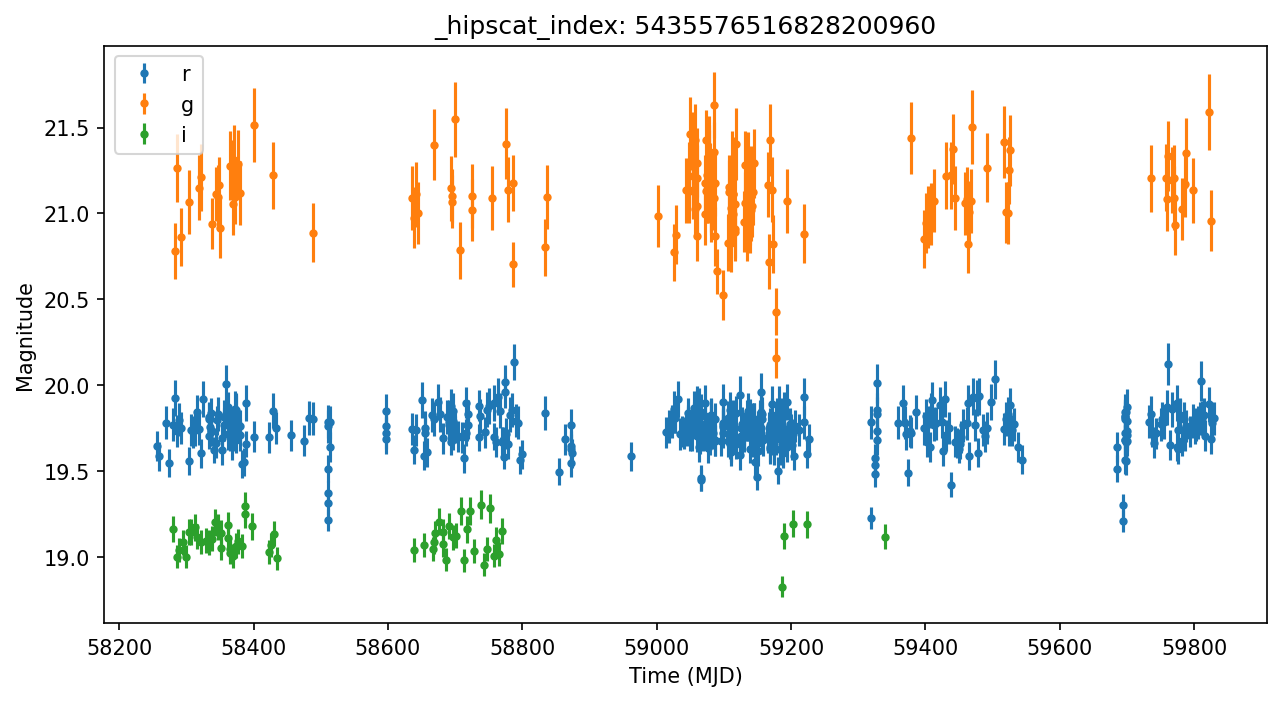

In [16]:
%%time
# Let's plot a lightcurve

# We'll select one randomly
ts = ens.select_random_timeseries(seed=1)  # seed provides a reproducible result

# Iterate through each band and plot
fig, ax = plt.subplots(1,1,figsize=(10,5), dpi=150)
for band in ts.data["band"].unique():
    band_ts = ts.data[ts.data["band"] == band]
    ax.errorbar(band_ts["mjd"], band_ts["mag"], yerr=band_ts["magerr"], fmt='.', label=f"{band}")

ax.set_title(f'_hipscat_index: {ts.meta["id"]}')
ax.set_ylabel("Magnitude")
ax.set_xlabel("Time (MJD)")
ax.legend()

# Find the object level information for our randomly selected timeseries
ens.object.loc[ts.meta["id"]].compute()

In [17]:
%%time
# Calculate Stetson K Metric for all lightcurves using the light_curve package
# Available Features: https://github.com/light-curve/light-curve-python?tab=readme-ov-file#available-features
from light_curve import StetsonK
stetson_k = StetsonK()

# Batch applies the function to all lightcurves
# TAPE automatically passes the appropriate columns to functions in the light_curve feature package
stet_ks = ens.batch(stetson_k, band_to_calc="r")
stet_ks.head(5, npartitions=-1)

Using generated label, result_1, for a batch result.
CPU times: user 3.78 s, sys: 2.75 s, total: 6.53 s
Wall time: 4.61 s


,stetson_K
_hipscat_index,
5433297910915661824,0.457164
5433297981908451328,0.755779
5433302909825581056,0.729091
5433303011608756224,0.760128
5433303088167387136,0.457796


In [18]:
# Let's assign this new column to the object table
ens.object.assign(stetson_K = stet_ks["stetson_K"]).update_ensemble()
ens.object # can see stetson_K column is now present

,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,parallax_error_gaia,parallax_over_error_gaia,pm_gaia,pmra_gaia,pmra_error_gaia,pmdec_gaia,pmdec_error_gaia,ra_dec_corr_gaia,ra_parallax_corr_gaia,ra_pmra_corr_gaia,ra_pmdec_corr_gaia,dec_parallax_corr_gaia,dec_pmra_corr_gaia,dec_pmdec_corr_gaia,parallax_pmra_corr_gaia,parallax_pmdec_corr_gaia,pmra_pmdec_corr_gaia,astrometric_n_obs_al_gaia,astrometric_n_obs_ac_gaia,astrometric_n_good_obs_al_gaia,astrometric_n_bad_obs_al_gaia,astrometric_gof_al_gaia,astrometric_chi2_al_gaia,astrometric_excess_noise_gaia,astrometric_excess_noise_sig_gaia,astrometric_params_solved_gaia,astrometric_primary_flag_gaia,nu_eff_used_in_astrometry_gaia,pseudocolour_gaia,pseudocolour_error_gaia,ra_pseudocolour_corr_gaia,dec_pseudocolour_corr_gaia,parallax_pseudocolour_corr_gaia,pmra_pseudocolour_corr_gaia,pmdec_pseudocolour_corr_gaia,astrometric_matched_transits_gaia,visibility_periods_used_gaia,astrometric_sigma5d_max_gaia,matched_transits_gaia,new_matched_transits_gaia,matched_transits_removed_gaia,ipd_gof_harmonic_amplitude_gaia,ipd_gof_harmonic_phase_gaia,ipd_frac_multi_peak_gaia,ipd_frac_odd_win_gaia,ruwe_gaia,scan_direction_strength_k1_gaia,scan_direction_strength_k2_gaia,scan_direction_strength_k3_gaia,scan_direction_strength_k4_gaia,scan_direction_mean_k1_gaia,scan_direction_mean_k2_gaia,scan_direction_mean_k3_gaia,scan_direction_mean_k4_gaia,duplicated_source_gaia,phot_g_n_obs_gaia,phot_g_mean_flux_gaia,phot_g_mean_flux_error_gaia,phot_g_mean_flux_over_error_gaia,phot_g_mean_mag_gaia,phot_bp_n_obs_gaia,phot_bp_mean_flux_gaia,phot_bp_mean_flux_error_gaia,phot_bp_mean_flux_over_error_gaia,phot_bp_mean_mag_gaia,phot_rp_n_obs_gaia,phot_rp_mean_flux_gaia,phot_rp_mean_flux_error_gaia,phot_rp_mean_flux_over_error_gaia,phot_rp_mean_mag_gaia,phot_bp_rp_excess_factor_gaia,phot_bp_n_contaminated_transits_gaia,phot_bp_n_blended_transits_gaia,phot_rp_n_contaminated_transits_gaia,phot_rp_n_blended_transits_gaia,phot_proc_mode_gaia,bp_rp_gaia,bp_g_gaia,g_rp_gaia,radial_velocity_gaia,radial_velocity_error_gaia,rv_method_used_gaia,rv_nb_transits_gaia,rv_nb_deblended_transits_gaia,rv_visibility_periods_used_gaia,rv_expected_sig_to_noise_gaia,rv_renormalised_gof_gaia,rv_chisq_pvalue_gaia,rv_time_duration_gaia,rv_amplitude_robust_gaia,rv_template_teff_gaia,rv_template_logg_gaia,rv_template_fe_h_gaia,rv_atm_param_origin_gaia,vbroad_gaia,vbroad_error_gaia,vbroad_nb_transits_gaia,grvs_mag_gaia,grvs_mag_error_gaia,grvs_mag_nb_transits_gaia,rvs_spec_sig_to_noise_gaia,phot_variable_flag_gaia,l_gaia,b_gaia,ecl_lon_gaia,ecl_lat_gaia,in_qso_candidates_gaia,in_galaxy_candidates_gaia,non_single_star_gaia,has_xp_continuous_gaia,has_xp_sampled_gaia,has_rvs_gaia,has_epoch_photometry_gaia,has_epoch_rv_gaia,has_mcmc_gspphot_gaia,has_mcmc_msc_gaia,in_andromeda_survey_gaia,classprob_dsc_combmod_quasar_gaia,classprob_dsc_combmod_galaxy_gaia,classprob_dsc_combmod_star_gaia,teff_gspphot_gaia,teff_gspphot_lower_gaia,teff_gspphot_upper_gaia,logg_gspphot_gaia,logg_gspphot_lower_gaia,logg_gspphot_upper_gaia,mh_gspphot_gaia,mh_gspphot_lower_gaia,mh_gspphot_upper_gaia,distance_gspphot_gaia,distance_gspphot_lower_gaia,distance_gspphot_upper_gaia,azero_gspphot_gaia,azero_gspphot_lower_gaia,azero_gspphot_upper_gaia,ag_gspphot_gaia,ag_gspphot_lower_gaia,ag_gspphot_upper_gaia,ebpminrp_gspphot_gaia,ebpminrp_gspphot_lower_gaia,ebpminrp_gspphot_upper_gaia,libname_gspphot_gaia,Norder_gaia,Dir_gaia,Npix_gaia,_DIST,nobs_total,stetson_K
npartitions=7,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Text(0, 0.5, 'Frequency')

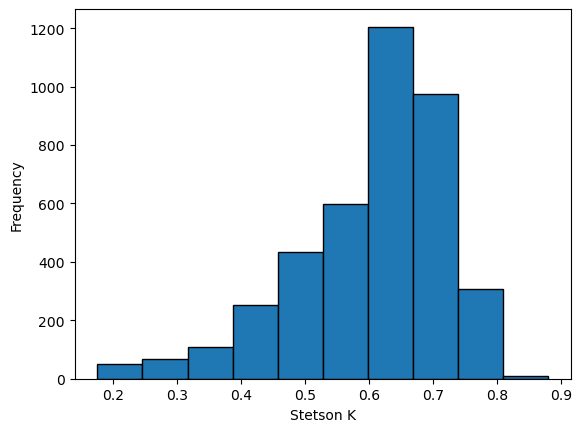

In [19]:
# Let's plot the distribution of stetson_k values
plt.hist(ens.object["stetson_K"], edgecolor="k")

plt.xlabel("Stetson K")
plt.ylabel("Frequency")